# scaredy rat uses raw data from EthoVision to analyze behavior over time. 

#### Be sure to restart the kernel after every use. To run all cells, go to Cell > Run All.
Known issues:
 - there won't be data for the 12th tone due to indexing issues. fix tbd.
 - 

for others, email me at li.anna@husky.neu.edu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import xlsxwriter
from openpyxl import load_workbook
import math
import time

In [2]:
def animal_read(filename,sheet):
    '''
    Returns corresponding animals for sheets
    Reads data into dataframe with long header removed.
    Uses correct labels as column labels.
    Uses time as row indexes.
    '''
    filepath = inpath + '\\' + filename
    df = pd.read_excel(filepath,sheetname=sheet,skip_footer=34,index_col=0)
    animal = df.iloc[31][0]
    print(filename + " " + sheet + " is " + animal)
    
    df = pd.read_excel(filepath,sheetname=sheet,skiprows=34,index_col=0,headers=0)
    df = df[1:]
    df.replace(to_replace='-',value=0,inplace=True)
    return(animal,df)

In [3]:
def find_tones(df):
    '''
    Creates dictionary of each tone. Values are
    dataframes for times at which each tone == 1.
    '''
    tones = {}
    i = 1
    while i <= 12: # number of tones
        num = str(i)
        label = 'Tone ' + num
        tone = pd.DataFrame(df[df[label] == 1])
        tones[i] = tone
        i += 1
    return(tones)

In [4]:
def find_pretones(df):
    '''
    Creates dictionary of each pretone. Values
    are dataframes for 30s before tone == 1
    '''
    pretones = {}
    i = 1
    while i<= 12:
        num = str(i)
        label = 'Tone ' + num #Column label for each tone
        
        tone = df[df[label] == 1] #Tone dataframe
        tonestart = tone.iloc[0] #Time for tone start
        
        starttime = math.floor(tonestart['Recording time']-30) #Time for pretone start
        endtime = math.floor(tonestart['Recording time']) #Time for pretone end
        itime = df.index.get_loc(starttime,method='bfill') #Index for pretone start
        etime = df.index.get_loc(endtime,method='bfill') #Index for pretone end
        
        pretone = df.iloc[itime:etime] #df for pretone
        pretones[i] = pretone #dictionary for all pretones
        i += 1
    return(pretones)

In [5]:
def find_shock_responses(df):
    '''
    Creates dictionary of each shock response. Values
    are dataframes for 5s after tone == 1
    '''
    sresponses = {}
    i = 1
    while i<= 11:
        num = str(i)
        label = 'Tone ' + num #Column label for each tone
        
        tone = df[df[label] == 1] #Tone dataframe
        toneend = tone.iloc[-1] #Time for tone end
        
        starttime = math.floor(toneend['Recording time']) #Time for sresponse start
        endtime = math.floor(toneend['Recording time'] + 5) #Time for sresponse end
        itime = df.index.get_loc(starttime,method='bfill') #Index for sresponse start
        etime = df.index.get_loc(endtime,method='bfill') #Index for sresponse end
        
        sresponse = df.iloc[itime:etime] #df for sresponse
        sresponses[i] = sresponse #dictionary for all sresponse
        i += 1
    return(sresponses)

In [6]:
def find_postshocks(df):
    '''
    Creates dictionary of each postshock. Values
    are dataframes for 5s after tone == 1
    '''
    pshocks = {}
    i = 1
    while i<= 11:
        num = str(i)
        label = 'Tone ' + num #Column label for each tone
        
        tone = df[df[label] == 1] #Tone dataframe
        toneend = tone.iloc[-1] #Time for tone end
        
        starttime = math.floor(toneend['Recording time'] + 5) #Time for pshock start
        endtime = math.floor(toneend['Recording time'] + 35) #Time for pshock end
        itime = df.index.get_loc(starttime,method='bfill') #Index for pshock start
        etime = df.index.get_loc(endtime,method='bfill') #Index for pshock end
        
        pshock = df.iloc[itime:etime] #df for pshock
        pshocks[i] = pshock #dictionary for all sresponse
        i += 1
    return(pshocks)

In [7]:
def get_total_dists(datadict):
    i = 1
    while i <= 12:
        epoch = datadict[i]
        dist = epoch['Distance moved']
        total = dist.sum()
        print()

In [8]:
def get_means(datadict,timebin):
    meanlist = []
    i = 1
    while i <= 11:
        epoch = datadict[i]
        vels = epoch['Velocity']
        mean = round(vels.mean(),3)
        meanlist.append(mean)
        i += 1
    means = pd.DataFrame(meanlist,columns=[timebin + ' Mean Velocity'])
    means.index = np.arange(1, len(means) + 1)
    return(means)

In [9]:
def get_meds(datadict,timebin):
    medlist = []
    i = 1
    while i <= 11:
        epoch = datadict[i]
        vels = epoch['Velocity']
        med = round(vels.median(),3)
        medlist.append(med)
        i += 1
    meds = pd.DataFrame(medlist,columns=[timebin + ' Median Velocity'])
    meds.index = np.arange(1, len(meds) + 1)
    return(meds)

In [10]:
def get_vels(df):
    '''
    Creates data of all velocities from
    original dataframe for plotting.
    '''
    tonevels = {}
    i = 1
    while i <= 12: # number of tones
        vels = []
        num = str(i)
        label = 'Tone ' + num
        tone = pd.DataFrame(df[df[label] == 1])
        vels.append(tone['Velocity'])
        tonevels[i] = vels
        i += 1
    return(tonevels)

In [11]:
def plot_vel_distr(veldict):
    i = 1
    f, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(15,5))
    while i <= 6:
        leg = 'Tone ' + str(i)
        data = veldict[i]
        sns.distplot(data,hist=False,axlabel='velocity (cm/s)',label=leg,ax=ax1)
        i += 1
    while i > 6 and i<= 12:
        leg = 'Tone ' + str(i)
        data = veldict[i]
        sns.distplot(data,hist=False,axlabel='velocity (cm/s)',label=leg,ax=ax2)
        i += 1
    return(f)

## Change variables in this cell only

In [12]:
## Be sure to put r before the path
inpath = r'C:\Users\Anna\Documents\Shansky Lab\BRF Darting\BRF Anna data\FC'
## Make sure the outpath folder exists already.
## The file does not need to exist; it will be created.
outpath = r'C:\Users\Anna\Documents\Shansky Lab\BRF Darting\scaredy rat results'
filename = 'Raw data-BRF Fear Conditioning-Trial     1.xlsx'
sheetname = 'Track-Arena 2-Subject 1'

In [13]:
## These are the actual function calls
## Takes a while to run due to size of sheet
ID,anim = animal_read(filename,sheetname)

tones = find_tones(anim)
pretones = find_pretones(anim)
shocks = find_shock_responses(anim)
pshocks = find_postshocks(anim)

tmeans = get_means(tones,'Tone')
ptmeans = get_means(pretones,'Pre-tone')
smeans = get_means(shocks,'Shock')
pshockmeans = get_means(pshocks,'Post-shock')
allmeans = pd.concat([tmeans, ptmeans, smeans, pshockmeans],axis=1)

tmeds = get_meds(tones,'Tone')
ptmeds = get_meds(pretones,'Pre-tone')
smeds = get_meds(shocks,'Shock')
pshockmeds = get_meds(pshocks,'Post-shock')
allmeds = pd.concat([tmeds, ptmeds, smeds, pshockmeds],axis=1)

Raw data-BRF Fear Conditioning-Trial     1.xlsx Track-Arena 2-Subject 1 is BRFF6


## Output data and figures will be under this cell

,Tone Mean Velocity,Pre-tone Mean Velocity,Shock Mean Velocity,Post-shock Mean Velocity
1,7.215,0.684,8.462,5.684
2,0.339,0.413,0.193,0.236
3,0.214,0.242,0.245,0.252
4,0.370,0.290,0.348,0.372
5,0.712,0.544,1.547,3.210
6,0.928,2.647,4.770,10.219
7,6.275,3.342,7.666,1.447
8,0.214,0.255,2.367,0.964
9,0.531,0.633,1.178,0.989
10,0.167,0.169,0.500,1.181


,Tone Median Velocity,Pre-tone Median Velocity,Shock Median Velocity,Post-shock Median Velocity
1,3.895,0.284,3.747,4.388
2,0.223,0.240,0.179,0.191
3,0.194,0.220,0.227,0.205
4,0.294,0.249,0.325,0.338
5,0.484,0.416,1.126,1.072
6,0.507,1.456,1.335,6.368
7,3.191,2.213,5.822,0.867
8,0.195,0.221,0.608,0.587
9,0.442,0.488,0.730,0.411
10,0.158,0.149,0.270,0.360


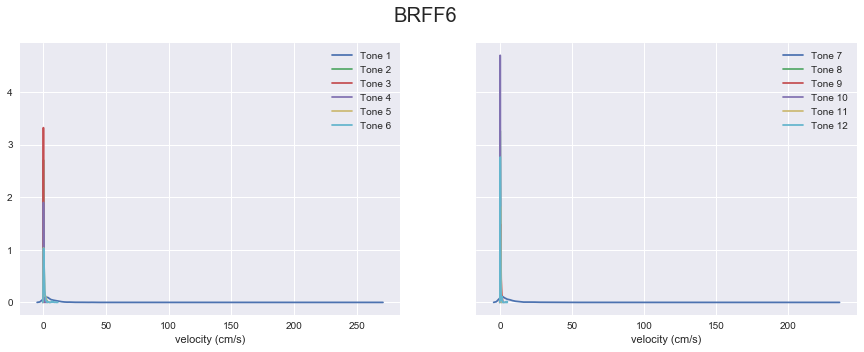

In [14]:
display(allmeans)
display(allmeds)
tvels = get_vels(anim)
plot_vel_distr(tvels)
plt.suptitle(ID, fontsize=20)
## Saves figures to same folder named by animal
outimg = outpath + '\\' + ID + '-vel-dist.jpg'
plt.savefig(outimg)
plt.show()

In [15]:
## Saves the data to a file named with current date.
i = time.strftime("%m.%d.%Y")
outfile = outpath + '\\scaredy-rat-' + i + '.xlsx'

writer = pd.ExcelWriter(outfile, engine='openpyxl') 

allmeans.to_excel(writer, ID)
allmeds.to_excel(writer, ID,startrow=13)

writer.save()

In [15]:
## Saves the data to a file named with current date.
i = time.strftime("%m.%d.%Y")
outfile = outpath + '\\scaredy-rat-' + i + '.xlsx'

writer = pd.ExcelWriter(outfile, engine='xlsxwriter')
allmeans.to_excel(writer, sheet_name=ID)
allmeds.to_excel(writer, sheet_name=ID,startrow=13)

writer.save()

#### future implementations:
 - conditional on whether or not data for last one is present
 - findpeaks_cwt maybe (from signal)
 - nested functions

# Test section
### (Code that may or may not work yet)